# Notebook for going towards reliabel real-proxy DA:

- How does the resampled proxy timeseries list look like
- is the proxy look up ok


In [846]:
cfg = {
#BASIC PARAMS
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'oro': None,
'reconstruct':['tsurf','d18O','prec'], 
'output_folder':'Speleo_full_recon', #in cwd
'output_file':'Echam_1_10_20',
'multi_model_prior': None, #None or a list where the first entry is a dictionary of dictionaries for the file paths and secord a dictionary with the orography files
'avg':None, 
'seed': 42, 
'check_nan':False, #mainly needed for iHadCM3, because of its missing years nans are introduced with 'resampled'
###PROXYS
#'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc'],#['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc'],#,'/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1600_1800.nc'],
'obs_var':[['d18O','d18O_precision']],#,['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1], #irrelevant for PPE
'time_scales': ['median'], 
'proxy_time':['0800','1999'], 
'resample': True,#True,
'resample_mode': 'linear',#'nearest',
'mask': 10, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20,40], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
#'timescales':[1],
'timescales':[1,5,10,20,40],
'reuse': True,#True, #e.g if a yearly resolved proxy is also to be used in the 5,10 year mean reconstruction
###PSM
'psm':['speleo'], 
'interpol':None, #None/'dw'
'var_psm': ['d18O'] ,
'speleo':{
    'weighting': None,#'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation': False, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
},
'icecore':{
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': False, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
},
#currently this only works for one Database files, probably at some point that needs to be more flexible
'linear':{
    'variable': 'tsurf' , #variable to regress against
    'type': 'anom' , #absolute value or anomaly
    'anom_time': None , #None for full simulation, or time-list 
    'uniform': None, # if you just want one linear formula to rule them all [slope, intercept]
    #names of the regression parameters in the proxy-db
    'slope': 'slope' ,
    'intercept': 'intercept',
    'error': 'error', #make sure that the error in the database info is really the regression error *variance*, not standard error.
},
###PSEUDOPROXY-EXPERIMENTS (variable comes from var_psm)
'ppe': {
    'use': False,
    'SNR': [5,5], #signal to noise variance ratio
    'noise_type': 'w', #'w'/'r'
    'red_noise_a': 0.32, #autocorrelation for red noise
    'multi_timescale': [[1],[1]], 
    'source': 'external', #internal/external
    'other_model': 
    {'vp':{'tsurf':'/home/ldap-server/draco/cleaned_data/final/CESM_tsurf_850_1850.nc',
    'prec':'/home/ldap-server/draco/cleaned_data/final/CESM_prec_850_1850.nc',
    'd18O':'/home/ldap-server/draco/cleaned_data/final/CESM_d18O_850_1850.nc',
    'evap': '/home/ldap-server/draco/cleaned_data/final/CESM_evap_850_1850.nc'}},
    'oro': '/home/ldap-server/draco/orographies/final/icesm_oro.nc',
    'metrics_ppe': ['Corr','p_value','p_bootstrap','eff_p_value','CE','RMSE','RMSPE','MAE','MAPE'],
    'psm' : {'speleo':{   'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'regular'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}, 'icecore': None},
},
    # cfg['ppe']['psm']= {'speleo':None, 'icecore': None} # if the config from above for the psm (which gives the obs-from-model) shall be different for the pseudoproxies.
#else just leave it as {'speleo':None, 'icecore': None} 
    
###KALMAN-FILTER
'time': ['0800','1999'], #covered by all models
'nens':100, #ensemble members
'reps':1, #Monte Carlo
'full_fields': False, 
'proxy_frac': None, #choose 100 random proxies
'extra_assi': 
    {
        'globalmean': ['tsurf','d18O','prec'], #None or list of variables
        'lat_mean': ['tsurf'], #None or list of variables
        'regionalmean': None, #None or list of variables
        'region':None, #None or list of list [[latS,latN],[latW,latE]] #specify the regions in 0-360 longitude system
        'prec_weighted': False, #if you want to get the precipitation weighted d18O
    },
'error_scale':1, 
'anomaly': 'BG+HX', #/ 'HX'
'anomaly_time': ['1600','1800'],#None,#['1500','1750'],#None,
'cov_loc': None,
#evaluation metrics (which do not rely on a true state)
'metrics': [None],#['rank_histogram','rank_histogram_posterior','CD'], #['None']
}

In [847]:
downsampled_paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       }
},

In [848]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [849]:
import sys
sys.path.append('/home/mchoblet/paleoda')

import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils

import copy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [850]:
import xarray as xr
import numpy as np
from types import SimpleNamespace

import dataloader
import utils
import psm_pseudoproxy
import kalman_filters
import evaluation

import tqdm
import os
import warnings
import copy

from numba import njit,prange,vectorize
import xskillscore as xss
import sys
import json

In [851]:
cfg=utils.config_check(cfg)
c=SimpleNamespace(**cfg)

In [852]:


#proxy databases and errors list of DAs, final time given by c.proxy_time.
#site has 0.+..., 1.+... to mark the distinct proxy dbs
pp_y_all,pp_r_all=utils.proxy_load(c)


#INSERTION FOR TESTING #its the same here
pp_y_all_c,pp_r_all_c=copy.deepcopy(pp_y_all),copy.deepcopy(pp_r_all)

#RESAMPLE PROXIES
pp_y_all,pp_r_all,times_list,lisst,lisst_r=utils.resample_wrapper(c,pp_y_all,pp_r_all)




#anomaly correction for proxies is done after pseudoproxies part
#timescales to reconstruct
if c.ppe['use']==False:
    time_res=c.timescales
    if 1 not in time_res:
        time_res=np.insert(time_res,0,1)
        
        #add empty lisst/lisst_r entry (Data-Array) to make algorithm work
        
        
        
else:
    #if using pseudoproxies: I implemented the option of having different TS for each Database, to facilitate some experiments where some locations only have specif timescale information
    timescales=np.unique(np.hstack(c.ppe['multi_timescale']))
    if 1 not in timescales:
        timescales=np.insert(timescales,0,1)
    time_res=np.sort(np.array(timescales))

>>>>>LOADING PROXY DATA
COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 113/113 [00:09<00:00, 12.07it/s]


In [854]:
if c.anomaly is not None:
    pp_y_all_a=utils.anomaly_proxies(c,lisst)
    #reasign original array
    lisst=pp_y_all_a
    #also calculate anomaly for 'truth'. HXfull_all_fin only passed as a dummy here
    if c.ppe['use']==True and c.ppe['source']=='external':
        _,truth=utils.anomaly_noproxies(c,HXfull_all_fin,truth)

In [855]:
#block size is largest time resolution
bs=time_res[-1]
#time resolutions without bs, reversed (backwards)
time_res_r=time_res[:-1][::-1]

if c.multi_model_prior is None:
    #set range to one such that the loop is just ran once (same as not multi-model prior)
    ran=1
else:
    print('Will compute a multi-model-prior!')
    dicts_paths=c.multi_model_prior[0]
    #eventually oros not provided (and also not needed)
    try:
        oros=c.multi_model_prior[1]
    except:
        pass
    ran=len(dicts_paths)
    model_names=list(c.multi_model_prior[0])

#empty list where I am going to save the values vectors!
values_vector_list=[]
MC_idx_list=[]

for i in range(ran):
    #for multi-model prior option change the paths and the 
    if c.multi_model_prior is not None:
        current_mod=model_names[i]
        cfg_copy=copy.deepcopy(cfg)
        cfg_copy['vp']=dicts_paths[current_mod]
        try:
            cfg_copy['oro']=oros[current_mod]
        except:
            pass

        ###
        #workaround to make sure the broken iHadCM3 years are removed
        if current_mod!='iHadCM3':
            cfg_copy['check_nan']=False
        ###


        utils.config_check(cfg)
        c2=SimpleNamespace(**cfg_copy)    
    else:
        c2=c        

    #PRIOR AND PROXY LOAD
    #annual and monthly priors
    prior, attributes, prior_raw=utils.prior_preparation(c2)

    #PSM
    #apply psm. List of DAs
    HXfull_all=utils.psm_apply(c2,prior,prior_raw, pp_y_all)

    #### BRING DATA TOGETHER
    #we have assured in the beginning, that the time-axis is the same for all proxy-dbs (.reindex-method)
    #at that step we lose the proxy-db specific metadata. The meta data is the reason why we can not concatenate the xarrays directly,
    #cause we need it for the PSMs

    # 2. Bring HXfull_all together
    #loop over dbs, bring into list
    data=[]
    sites=[]
    lons=[]
    lats=[]
    for db in HXfull_all:
            data.append(db.values)
            sites.append(db.site.values.tolist())
            lons.append(db.lon.values.tolist())
            lats.append(db.lat.values.tolist())
            #time_l.append(i.time)

    ax=db.get_axis_num('site')
    data=np.concatenate(data,axis=ax)
    sites=np.concatenate(sites,axis=0)
    lons=np.concatenate(lons,axis=0)
    lats=np.concatenate(lats,axis=0)

    #create dataarray
    HXfull_all_fin=xr.DataArray(data,coords=dict(time=HXfull_all[0].time.values,site=sites))
    HXfull_all_fin['lat']=('site',lats)
    HXfull_all_fin['lon']=('site',lons)
    #count databasemembers and add it as an attribute
    integers=(list(map(int,list(map(float,sites)))))
    HXfull_all_fin.attrs['DB_members']=np.unique(integers,return_counts=True)[1]        

    ###ANOMALY FOR EVERYTHING EXCEPT THE PROXIES.
    if c.anomaly is not None:
        HXfull_all_a,prior_a=utils.anomaly_noproxies(c,HXfull_all_fin,prior)
        
        ###TESTING: save a copy
        HXfull_all_fin_c=copy.deepcopy(HXfull_all_fin)
        prior_c=copy.deepcopy(prior)
        
        #assign to original arrays
        HXfull_all_fin=HXfull_all_a
        prior=prior_a

    ####EXTRA ASSIMILATATED VALUES
    extra_list,names,lengths,names_short=utils.extra_assimil(c2,prior,prior_raw,HXfull_all_fin)

    #CREATING THE PRIOR VECTOR
    #we stack all the variables we want to assimilate together into one vector.
    #it is faster to assimilate all variables at once than to repeat the calculations for tsurf, prec, d18O... separately
    #This is a structure we can not easily pack into a useful xarray-DataArray (that keeps track of coordinates and stuff)
    #Therefore from that point on I store the relevant info on which part of the vector is what in some additional vectors:
    #length_vector, names_vector, names_short vector
    #cfg['reconstruct'] contains all the variables are goint to be reconstructed

    #If you are only interested into a global/regional/latitudinal/mean', set 'full_fields' in config to false.
    #This way we don't reconstruct the field, which is equivallent as long as no localization is used.

    #The proxy estimates from HXfull_all_fin are carried within that vector, because I need to use the updated proxy estimates
    #for the Multi-time-scale DA.

    #HOW TO SPLIT AGAIN AFTERWARDS
    #splitted=np.split(values_vector,split_vector,axis=-1)
    #xr.DataArray(splitted[0],coords=dict(time=time_array,site=coordinates)).unstack('site')

    if c2.full_fields:
        #stack prior variables, secure right shape
        prior_stacked=prior.stack(site=('lat','lon')).transpose('time','site')

        #save coordinates for later when remaking the prior xarray
        coordinates=prior_stacked['site']

        #store number of elements per field, coordinates and short name for each part of the vector
        length_init=np.repeat(len(coordinates),len(c.reconstruct))
        names_init=np.repeat(coordinates.values,len(c.reconstruct))
        names_short_init=list(c.reconstruct)

        #bring stacked variables into one vector and concatenate that list
        #depending on 

        values=[]
        #for v in prior_stacked:
        for v in c2.reconstruct:
            values.append(prior_stacked[v].values)
        values=np.concatenate(values,axis=-1)

        #add extra_list from previous step
        values_vector=np.concatenate([values,extra_list],axis=-1)

    else:
        #initialize lists as empty such that it fits the rest
        length_init=[]
        names_init=[]
        names_short_init=[]
        #values_vector starts with extra_list from previous step
        values_vector=extra_list
        coordinates=None

    names_vector=np.concatenate([names_init,names],axis=-1)
    length_vector=np.concatenate([length_init,lengths])
    names_short_vector=np.concatenate([names_short_init,names_short])
    split_vector=np.cumsum(length_vector,dtype=int)[:-1] #can be applied to values_vector with numby split


    #get position where proxy-estimates start in the vector
    if c2.full_fields:
        proxy_start=int(split_vector[len(c.reconstruct)-1])
        try:
            proxy_end=int(split_vector[(len(c.reconstruct)-1+len(c.obsdata))])
        except:
            #case that only proxy estimates saved
            proxy_end=None
    else:
        proxy_start=0
        proxy_end=int(split_vector[(len(c.obsdata))])

    #if c.multi_model_prior is not None:
        #save al values_vectors in a list. proxy_names and stuff irrelevant because its the same everytime
        #(models were regridded to a common grid)
    values_vector_list.append(values_vector)

    #compute separate monte carlo indices for each model (brings in more randomnes)
    MC_idx=dataloader.random_indices(c.nens,prior.time.shape[0]-bs-1,c.reps,seed=c.seed + i)
    MC_idx_list.append(MC_idx)

MC_idx_list=np.array(MC_idx_list)
truth=None

Load d18O  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc
computing yearly average
USING SPELEO PSM
COMPUTE ANOMALIES IN MODE: BG+HX


In [856]:
#Create list of availables sites at each timescale
#this is necessary for getting the right proxy estimates during the Multi-time-scale DA
sites_avail=[]
for l in lisst:
    sites_avail.append(l.site.values)

#Get indices in values_vector for available sites at each timescale
#mini hack to speed up the search of the indices: only look into names_vector part where there actually proxies
#reduce names vector to proxy-names
proxy_names=names_vector[proxy_start:proxy_end]
#hack for only higher than annual reconstruction
if 1 not in c.timescales:
    idx_list=[[proxy_start+np.argwhere(proxy_names==al)[0][0] for al in b] for b in sites_avail[1:]]
    idx_list.insert(0,[])
else:
    idx_list=[[proxy_start+np.argwhere(proxy_names==al)[0][0] for al in b] for b in sites_avail]

In [857]:
#indices of proxy records available for largest timescale
idx_bs=idx_list[-1]
#backwards proxy and proxy error list
lisst_bw=lisst[:-1][::-1]
lisst_r_bw=lisst_r[:-1][::-1]
# number of assimilated values, years and blocks to reconstruct, repetitions and ensemble members
num_vals=values_vector.shape[1]
num_times=len(times_list[0]) #basic time scale needs to be annual
num_blocks=int(np.ceil(num_times/bs)) #  this was incorrect: num_times//bs
reps=c.reps

In [858]:
if c.multi_model_prior is None:
    nens=c.nens
else:
    nens=c.nens*ran

#RANDOM INDICES FOR PRIOR
#MC_idx=dataloader.random_indices(c.nens,prior.time.shape[0]-bs-1,c.reps,seed=None)

#Initialize mean and std array for saving reconstruction
mean_array=np.empty((reps,num_times,num_vals))
std_array=np.empty((reps,num_times,num_vals))

print('Start Multitimescale DA loop.')

Start Multitimescale DA loop.


In [859]:
#Monte carlo repetitions
for r in tqdm.tqdm(range(reps)):
    #create prior_block form values vector, in the loops we create a similar variable called prior_block (be careful to take deepcopy if necessary)


    prior_b=utils.prior_block_mme(values_vector_list,bs,MC_idx_list[:,r])
    
    if c.anomaly is not None:
        prior_b=(prior_b-prior_b.mean(axis=1)[:,None,:])
    
    

    #proxy selection for that repetion

    if c.proxy_frac is not None:
        proxy_frac_idx = [p[r] for p in proxy_frac]
        #reversed proxy_frac_idx without last list
        proxy_frac_idx_r=list(reversed(proxy_frac_idx[:-1]))

    #compute mean and anomaly for prior_block, to that end save the shape, flatten, compute, unflatten
    #flattening just keeping the blocksize dimension (along which mean is calculated)
    shape=prior_b.shape
    prior_flat=prior_b.reshape(bs,-1)
    m_bs,a_bs=utils.anomean_with_numba(prior_flat,bs)
    m_bs=m_bs.reshape((1,shape[1],shape[2]))
    a_bs=a_bs.reshape(shape)

    #Available proxy estimates for largest time_scale
    HXf_bs_m=m_bs[:,:,idx_bs]

    #Optional dictionaries used for saving rank histograms if they are to be calculated
    rank_dic={}
    if 'rank_histogram' in c.metrics:
        for tres in time_res:
            rank_dic[str(tres)]=[]
    rank_dic_post={}
    if 'rank_histogram_posterior' in c.metrics:
        for tres in time_res:
            rank_dic_post[str(tres)]=[]

    #loop over blocks
    for i in range(num_blocks):
        #assimilate block size means directly (saves one anomean calculation)
        current_time=times_list[-1][i]
        Y=lisst[-1].isel(time=i)
        R=lisst_r[-1].isel(time=i)

        #eventually only select some proxies
        if c.proxy_frac is not None:
            Y=Y[proxy_frac_idx[-1]]
            R=R[proxy_frac_idx[-1]]

        #indices where Y is not nan
        mask=~np.isnan(Y)

        Y=Y.dropna('site').values
        R=R.dropna('site').values

        #Get prior forecast (Ne x Nx)
        Xf=m_bs[0].copy() 
        
        
        if len(Y)>0:
            #Additionaly mask the the prior estimates as given by availability
            HXf=copy.deepcopy(HXf_bs_m[0])
            if c.proxy_frac is not None:
                HXf=HXf[:,proxy_frac_idx[-1]]
            #option for covariance localization

            if c.cov_loc is not None:
                #necessary copy operations can take up to a ms!
                PH_loc_bs=copy.deepcopy(PH_loc)
                HPH_loc_bs=copy.deepcopy(HPH_loc)
                if c.proxy_frac is not None:
                    PH_loc_bs=PH_loc_bs[:,proxy_frac_idx[-1]]
                    HPH_loc_bs=HPH_loc_bs[proxy_frac_idx[-1]][:,proxy_frac_idx[-1]]
                PH_loc_bs=PH_loc_bs[:,mask]
                HPH_loc_bs=HPH_loc_bs[:,mask]

            HXf=HXf[:,mask] # Ne x Ny 
            #posterior (Has shape Nx )

            if c.cov_loc is not None:
                Xf_post=kalman_filters.ENSRF_direct_loc(Xf.T,HXf.T,Y,R*c.error_scale,PH_loc_bs, HPH_loc_bs)
            else:
                Xf_post=kalman_filters.ETKF(Xf.T,HXf.T,Y,R*c.error_scale) #input (Nx,Ne),(Ny,Ne),(Ny,1),(Ny,1)
            
            
            #add assimilated mean back to previous anomalies
            prior_block=utils.mean_plus_anoms(Xf_post.T,a_bs)
        else:
            prior_block=copy.deepcopy(prior_b)
            
        Xf_post_c=copy.deepcopy(Xf_post)
        #to-delete:
        prior_block_c=copy.deepcopy(prior_block)
        
        #eventually compute rank histograms, requires xr-DataArrays (time dimension is a dummy here)

        if 'rank_histogram' in c.metrics:

            HXf_xr=xr.DataArray(HXf,dims=('time','site'))
            Y_xr=xr.DataArray(Y,dims='site')
            rank=xss.rank_histogram(Y_xr,HXf_xr,dim='site',member_dim='time')
            rank_dic[str(bs)].append(rank)

        if 'rank_histogram_posterior' in c.metrics:
            Y_xr=xr.DataArray(Y,dims='site')
            idx_res=idx_list[-1]
            HXf_post=Xf_post[idx_res,:][mask].T
            HXf_post_xr=xr.DataArray(HXf_post,dims=('time','site'))
            rank=xss.rank_histogram(Y_xr,HXf_post_xr,dim='site',member_dim='time')
            rank_dic_post[str(bs)].append(rank)

        
        #loop over all other resolutions (backwards)
        for ii,res in enumerate(time_res_r):
            #proxy indices for that time_res
            idx_res=idx_list[:-1][::-1][ii]
            if res!=1:
                #compute anomalies and mean
                prior_flat=prior_block.reshape(bs,-1)
                mean_res,anom_res=utils.anomean_with_numba(prior_flat,res) #prior_flat not changed

                mean_res=mean_res.reshape((bs//res,nens,num_vals))
                anom_res=anom_res.reshape(shape)
            else:
                anom_res=np.zeros((shape))
                mean_res=prior_block

            #loop over sub_index in block, computed via true divison (e.g. 50/25 = 2)
            bs_mod_res=bs//res
            for sub_index in range(bs_mod_res):

                #issue of endings not matching (e.g. when running from 851-1849 in 20 year blocks, last block is not complete)
                #this is not a super nice solution. better would be to adapt the list where the subindices come from
                #probably better to build some extra code for last iteration and checking here everytime


                if sub_index * res + i*bs < num_times:

                    #get the current proxies at the right time
                    Y=lisst_bw[ii][i*bs_mod_res+sub_index]


                    #eventually slice
                    if c.proxy_frac is not None:
                        Y=Y[proxy_frac_idx_r[ii]]


                    #which proxies are available?
                    mask=~np.isnan(Y)
                    Y=Y.dropna('site').values


                    if len(Y)>0:
                        R=lisst_r_bw[ii][i*bs_mod_res+sub_index]
                        #eventually slice
                        if c.proxy_frac is not None:
                            R=R[proxy_frac_idx_r[ii]]

                        R=R.dropna('site').values
                        Xf=mean_res[sub_index,:]
                        #get averaged proxy estimates + available proxies
                        HXf=mean_res[sub_index,:][:,idx_res]

                        #apply proxy fraction
                        if c.proxy_frac is not None:
                            HXf=HXf[:,proxy_frac_idx_r[ii]]

                        if c.cov_loc is not None:
                            #necessary copy operations can take up to a ms!
                            PH_loc_bs=copy.deepcopy(PH_loc)
                            HPH_loc_bs=copy.deepcopy(HPH_loc)
                            if c.proxy_frac is not None:
                                PH_loc_bs=PH_loc_bs[:,proxy_frac_idx[-1]]
                                HPH_loc_bs=HPH_loc_bs[proxy_frac_idx[-1]][:,proxy_frac_idx[-1]]
                            PH_loc_bs=PH_loc_bs[:,mask]
                            HPH_loc_bs=HPH_loc_bs[:,mask]


                        #slice according to mask
                        HXf=HXf[:,mask]  # Ne x Ny 

                        if c.cov_loc is not None:
                            Xf_post=kalman_filters.ENSRF_direct_loc(Xf.T,HXf.T,Y,R*c.error_scale,PH_loc_bs, HPH_loc_bs)
                        else:
                            Xf_post=kalman_filters.ETKF(Xf.T,HXf.T,Y,R*c.error_scale) #input needs to be (Nx,Ne),(Ny,Ne),(Ny,1),(Ny,1)            

                    #case that no proxies are available
                    else:
                        Xf_post=mean_res[sub_index,:].T

                    #replace prior_block values
                    start=sub_index*res
                    end=(sub_index+1)*res

                    try:
                       # import pdb
                        #pdb.set_trace()
                        prior_block[start:end]=utils.mean_plus_anoms(Xf_post.T,anom_res[start:end])
                        

                    except:
                        import pdb
                        pdb.set_trace()

                    #eventually compute rank histograms, requires xr-DataArrays (time dimension is a dummy here)
                    if 'rank_histogram' in c.metrics:
                        HXf_xr=xr.DataArray(HXf,dims=('time','site'))
                        Y_xr=xr.DataArray(Y,dims='site')
                        rank=xss.rank_histogram(Y_xr,HXf_xr,dim='site',member_dim='time')
                        rank_dic[str(res)].append(rank)

                    if 'rank_histogram_posterior' in c.metrics:
                        Y_xr=xr.DataArray(Y,dims='site')
                        HXf_post=Xf_post[:,idx_res][:,mask]
                        HXf_post_xr=xr.DataArray(HXf_post,dims=('time','site'))
                        rank=xss.rank_histogram(Y_xr,HXf_post_xr,dim='site',member_dim='time')
                        rank_dic_post[str(res)].append(rank)                   
                else:
                    pass

        #import pdb
        #pdb.set_trace()

        #compute mean values in block (along ensemble)
        mean_block=np.mean(prior_block,axis=1)
        std_block=np.std(prior_block,axis=1)

        #fill mean_array at that part for that repetition
        block_start=bs*i
        block_end=bs*(i+1)

        if block_end>num_times:

            mean_array[r,block_start:block_end,:]=mean_block[:bs-(block_end-num_times),:]
            std_array[r,block_start:block_end,:]=std_block[:bs-(block_end-num_times),:]
        else:
            mean_array[r,block_start:block_end,:]=mean_block
            std_array[r,block_start:block_end,:]=std_block

100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


In [867]:
def quick_filt(ts,cutoff=1/30):
    from scipy.signal import butter, lfilter, filtfilt

    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=6):
        #filtfilt does not introduce a time-lag in comparison to butterworth 
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        #y = lfilter(b, a, data)
        return y

    return butter_lowpass_filter(ts,cutoff,fs=1,order=4)

In [901]:
def gmt_together(folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/', names=['Echam','GISS','iCESM','isoGSM','iHadCM3','mme','mme_nogiss']):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    plt.figure(figsize=(16,8))
    plt.locator_params(nbins=10)
    #colors=sns.color_palette('colorblind', n_colors=len(names))
    colors=sns.color_palette('tab10', n_colors=len(names))
    plt.title('GMT reconstruction from SISALv2', fontsize=20)
    
    for i,n in enumerate(names):
        string=folder + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'),cutoff=1/30)
        #choose different cut off
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(tsurf,label=n, color=colors[i])
        #plt.fill_between(np.arange(1200), tsurf - std, tsurf + std, color=colors[i], alpha=0.2)

        
    plt.ylabel(r'$\Delta$ T',fontsize=18)
    plt.xlabel(r'Year AD',fontsize=18)
    plt.legend(loc='lower right')
    plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))

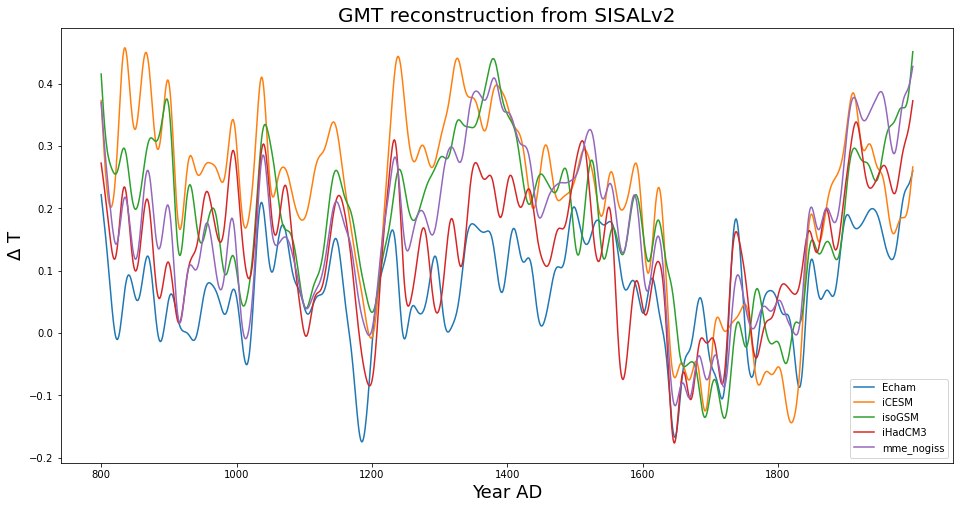

In [904]:
gmt_together(names=['Echam','iCESM','isoGSM','iHadCM3','mme_nogiss'])

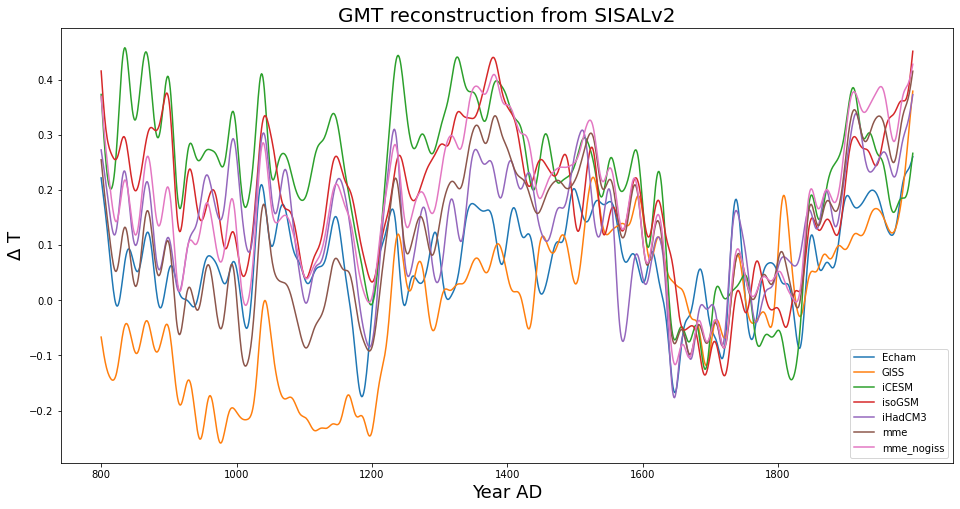

In [911]:
gmt_together()

In [914]:
downsampled_paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/downsampled/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/downsampled/iHADCM3_slp_801_1952.nc',
       }
}

In [906]:
def gmt_separate(folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/', names=['Echam','GISS','iCESM','isoGSM','iHadCM3'],paths=downsampled_paths):
    """
    Which timescales are used? First 1,5,10,20,40
    """
    colors=sns.color_palette('colorblind', n_colors=len(names))
    
    for i,n in enumerate(names):
        plt.figure(figsize=(12,8))
        plt.locator_params(nbins=10)
        plt.title(('GMT for model'+n), fontsize=20)
        
        string=folder + n + '_800_1999.nc'
        tsurf=xr.open_dataset(string)['gm_tsurf']
        tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'))
        std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
        plt.plot(tsurf,label='reconstruction', color=colors[i])
        plt.fill_between(tsurf, tsurf - std, tsurf + std, color=colors[i], alpha=0.2)
    
        #load prior model
        tsurf=xr.open_dataset(paths[n]['tsurf'])['tsurf']
        tsurf=utils.globalmean(tsurf)
        tsurf=tsurf-tsurf.sel(time=slice('1600','1800')).mean('time')
    
        plt.plot(tsurf,label='model', color=colors[i])
    
        plt.ylabel(r'\Delta T')
        plt.legend(loc='lower right')
        
        plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))
        plt.show()

In [926]:
downsampled_paths

{'iCESM': {'d18O': '/home/mchoblet/paleoda/data/model_data/downsampled/CESM_d18O_850_1850.nc',
  'evap': '/home/mchoblet/paleoda/data/model_data/downsampled/CESM_evap_850_1850.nc',
  'prec': '/home/mchoblet/paleoda/data/model_data/downsampled/CESM_prec_850_1850.nc',
  'tsurf': '/home/mchoblet/paleoda/data/model_data/downsampled/CESM_tsurf_850_1850.nc'},
 'isoGSM': {'d18O': '/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_d18O_851_1850.nc',
  'evap': '/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_evap_851_1850.nc',
  'prec': '/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_prec_851_1850.nc',
  'tsurf': '/home/mchoblet/paleoda/data/model_data/downsampled/CCSM_tsurf_851_1850.nc'},
 'Echam': {'d18O': '/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_d18O_850_1849.nc',
  'evap': '/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_evap_850_1849.nc',
  'prec': '/home/mchoblet/paleoda/data/model_data/downsampled/ECHAM5_prec_850_1849.nc',
  'tsurf': '/h

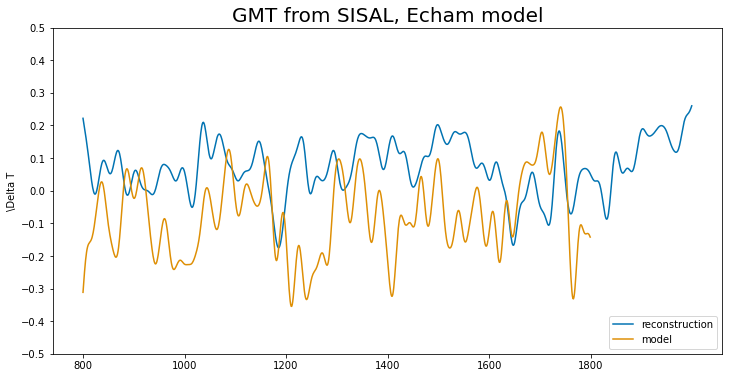

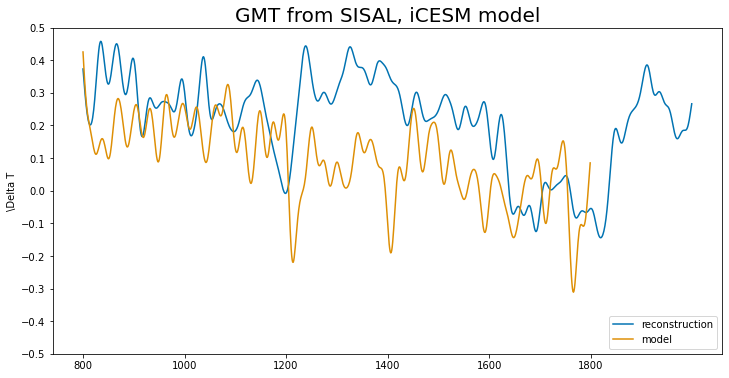

Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


In [936]:
folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/'
names=['Echam','GISS','iCESM','isoGSM','iHadCM3']
paths=downsampled_paths  
colors=sns.color_palette('colorblind', n_colors=len(names))

for i,n in enumerate(names):
    plt.figure(figsize=(12,6))
    plt.locator_params(nbins=10)
    plt.title(('GMT from SISAL, '+n +' model'), fontsize=20)

    string=folder + n + '_800_1999.nc'
    tsurf=xr.open_dataset(string)['gm_tsurf']
    tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'))
    std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
    plt.plot(np.arange(1200),tsurf,label='reconstruction', color=colors[0])
    #plt.fill_between(tsurf, tsurf - std, tsurf + std, color=colors[i], alpha=0.2)

    #load prior model
    if n=='iHadCM3':
        check=True
    else:
        check=False
    tsurf_2=dataloader.annual_mean(xr.open_dataset(paths[n]['tsurf'])['tsurf'],check_nan=check)
    tsurf_2=utils.globalmean(tsurf_2)
    tsurf_2=quick_filt(tsurf_2-tsurf_2.sel(time=slice('1600','1800')).mean('time'))

    plt.plot(tsurf_2,label='model', color=colors[1])

    plt.ylabel(r'\Delta T')
    plt.legend(loc='lower right')

    plt.ylim(-0.5,0.5)
    plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))
    plt.show()

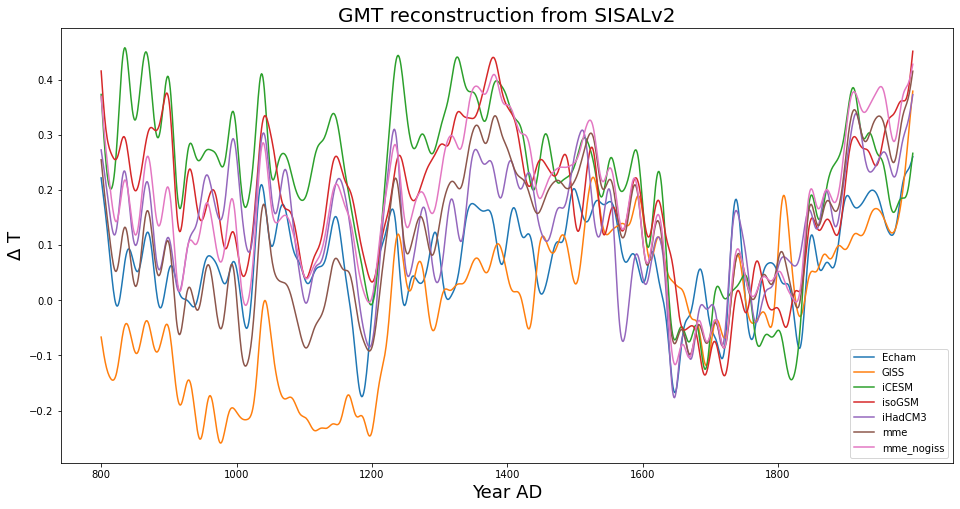

In [905]:
gmt_together()

([<matplotlib.axis.XTick at 0x7f8bf6d10be0>,
 [Text(0, 0, '800'),
  Text(200, 0, '1000'),
  Text(400, 0, '1200'),
  Text(600, 0, '1400'),
  Text(800, 0, '1600'),
  Text(1000, 0, '1800')])

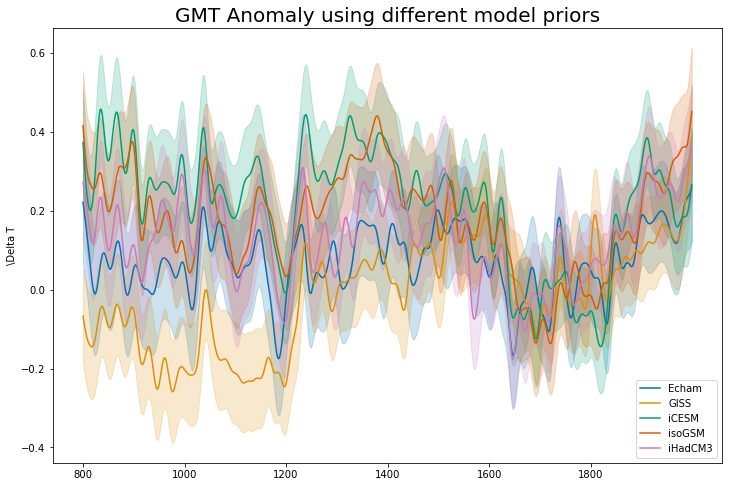

In [881]:
folder='/home/mchoblet/paleoda/results/experiments/GMT_from_speleos/'
names=['Echam','GISS','iCESM','isoGSM','iHadCM3','mme','mme_nogiss']

"""
Which timescales are used? First 1,5,10,20,40
"""
plt.figure(figsize=(12,8))
plt.locator_params(nbins=10)
colors=sns.color_palette('colorblind', n_colors=len(names))
plt.title('GMT Anomaly using different model priors', fontsize=20)

for i,n in enumerate(names[:-2]):
    string=folder + n + '_800_1999.nc'
    tsurf=xr.open_dataset(string)['gm_tsurf']
    tsurf=quick_filt(tsurf-tsurf[800:1000].mean('time'),cutoff=1/30)
    #choose different cut off
    std=quick_filt(xr.open_dataset(string)['gm_tsurf_std'],cutoff=1/40)
    plt.plot(tsurf,label=n, color=colors[i])
    plt.fill_between(np.arange(1200),tsurf - std, tsurf + std, color=colors[i], alpha=0.2)


plt.ylabel(r'\Delta T')
plt.legend(loc='lower right')
plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))

In [880]:
plt.plot(tsurf,label=n, color=colors[i])
plt.fill_between(np.arange(1200),tsurf - std, tsurf + std, color=colors[i], alpha=0.2)

In [ ]:
tsurf

In [860]:
#take mean along Monte Carlo
mean_array_final=mean_array.mean(axis=0)
std_array_final=std_array.mean(axis=0)      
print('Finished multitimescale DA')

#SAVING: SPLITTING UP THE VECTOR
#Now we have to resplit everything, and eventually also calculate PPE evaluation metrics
splitted_mean_16_18=np.split(mean_array_final,split_vector,axis=-1)
splitted_std_16_18=np.split(std_array_final,split_vector,axis=-1)

Finished multitimescale DA


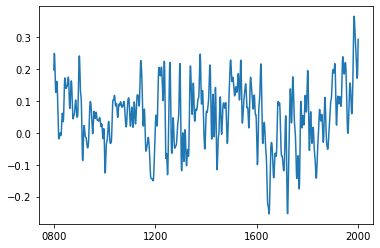

In [864]:
#only annual
cutoff=1/10
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_16_18[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

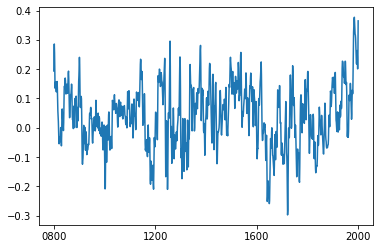

In [810]:
#only annual
cutoff=1/5
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_1_5_10_20_40[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

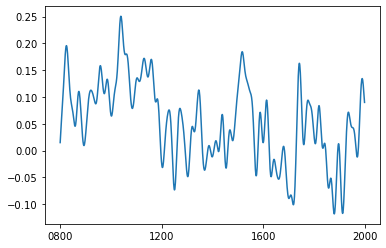

In [794]:
#only annual
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_1[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

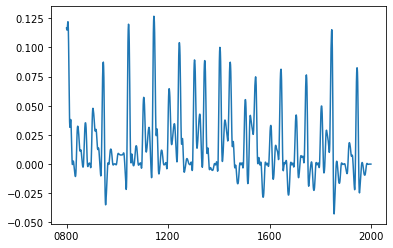

In [792]:
#only annual
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_10[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

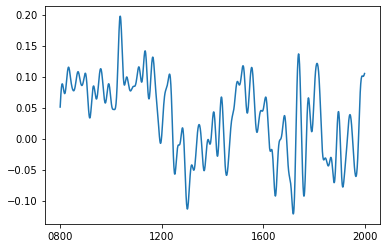

In [446]:
#only annual
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_none_1ts[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

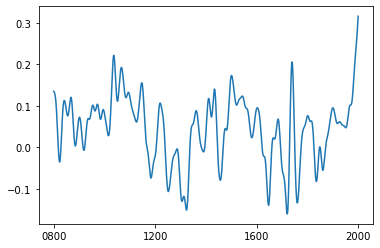

In [462]:
#noreuse
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_none_noreuse[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

In [478]:
#reuse only 1/10/20
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_none_reuse[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

In [497]:
#frac (1/10/20/40)
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_frac_reuse[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

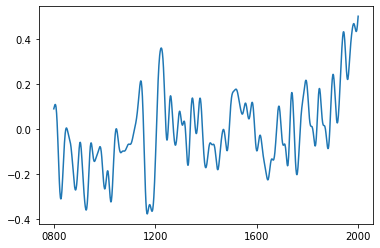

In [528]:
#nopsm, reuse (1/5/10/20/40), minir
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_minir[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

([<matplotlib.axis.XTick at 0x7f8bf968c640>,
 [Text(0, 0, '0'),
  Text(200, 0, '200'),
  Text(400, 0, '400'),
  Text(600, 0, '600'),
  Text(800, 0, '800'),
  Text(1000, 0, '1000'),
  Text(1200, 0, '1200'),
  Text(1400, 0, '1400'),
  Text(1600, 0, '1600'),
  Text(1800, 0, '1800')])

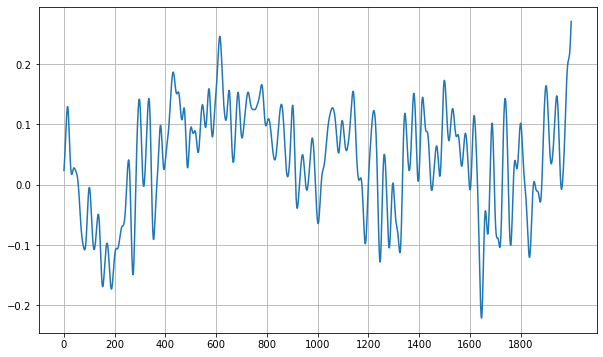

In [630]:
#nopsm, reuse (1/5/10/20/40), minir
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

plt.figure(figsize=(10,6))
plt.grid()
    
up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_1540_00[1]),cutoff,fs,order=4)
plt.plot(up_filt)#.shape
plt.locator_params(nbins=10)

plt.xticks(ticks=np.arange(0,2000,200),labels=list(map(str,np.arange(0,2000,200))))

([<matplotlib.axis.XTick at 0x7f8c0ef756c0>,
 [Text(0, 0, '800'),
  Text(200, 0, '1000'),
  Text(400, 0, '1200'),
  Text(600, 0, '1400'),
  Text(800, 0, '1600'),
  Text(1000, 0, '1800')])

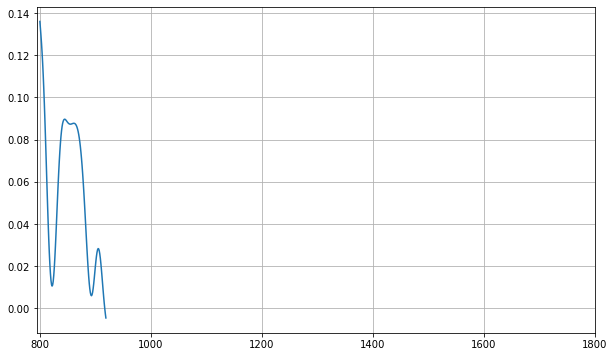

In [652]:
#nopsm, reuse (1/5/10/20/40), minir
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

plt.figure(figsize=(10,6))
plt.grid()
    
up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_10[1]),cutoff,fs,order=4)
plt.plot(up_filt)#.shape
plt.locator_params(nbins=10)

plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))

In [614]:
#nopsm, reuse (1/5/10/20/40), minir
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

plt.figure(figsize=(10,6))
plt.grid()
    
up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_minir[1]),cutoff,fs,order=4)
plt.plot(up_filt)#.shape
plt.locator_params(nbins=10)

plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_1540[1]),cutoff,fs,order=4)
plt.plot(up_filt,color='green')#.shape


up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_120[1]),cutoff,fs,order=4)
plt.plot(up_filt,color='red')#.shape

plt.locator_params(nbins=10)

plt.xticks(ticks=np.arange(0,1200,200),labels=list(map(str,np.arange(800,2000,200))))

#plt.set_xticklabels()

([<matplotlib.axis.XTick at 0x7f8bfbd68460>,
 [Text(0, 0, '800'),
  Text(200, 0, '1000'),
  Text(400, 0, '1200'),
  Text(600, 0, '1400'),
  Text(800, 0, '1600'),
  Text(1000, 0, '1800')])

['800', '1000', '1200', '1400', '1600', '1800']

In [423]:
#nopsm (1/5/10/20/40). anom-anders?
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_none_1600_nopsm[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt)#.shape

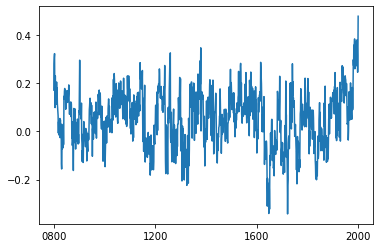

In [422]:
plt.plot(times_list[0],np.concatenate(splitted_mean_none_1600_nopsm[1]))#.shape

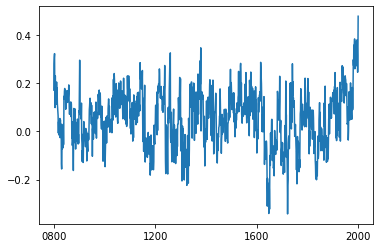

In [299]:
#mit allen zeitskalen, für d18O, db 1600 - 1900. no fractionation. good anomaly (1600-1900)

plt.plot(times_list[0],np.concatenate(splitted_mean_none_1600_a[1]))


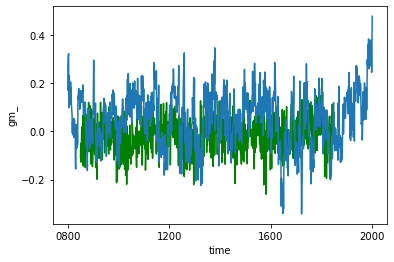

In [298]:
#mit allen zeitskalen, für d18O, db 1600 - 1900. no fractionation. good anomaly (1600-1900)

utils.globalmean(prior['d18O']).plot.line('-',c='green')
plt.plot(times_list[0],np.concatenate(splitted_mean_none_1600_a[1]))


#no prior block anomaly correction

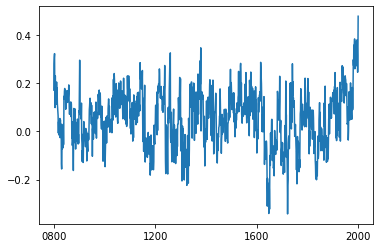

In [321]:
plt.plot(times_list[0],np.concatenate(splitted_mean_none_1600_a_2[1]))


In [300]:
from scipy.signal import butter, lfilter, filtfilt

def butter_lowpass(cutoff, fs, order=6, kf=1.2):
    # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
    #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
    #' aliasing small
    #fs is basic timestep (min_ts)
    #nyquist frequency
    nyq = 0.5 * fs 
    normal_cutoff = cutoff / nyq * kf
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=6):
    #filtfilt does not introduce a time-lag in comparison to butterworth 
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    #y = lfilter(b, a, data)
    return y

In [322]:
cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt=butter_lowpass_filter(np.concatenate(splitted_mean_none_1600_a_2[1]),cutoff,fs,order=4)

In [352]:
np.max(up_filt2-up_filt)

0.1347599974330684

In [378]:
#mit infiltration

cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt3=butter_lowpass_filter(np.concatenate(splitted_mean_none_1600_frac[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt3)

In [371]:
np.max(up_filt3-up_filt)

0.19787613838407922

In [375]:
1961-800

1161

array([0.15798054, 0.15866692, 0.15921853, ..., 0.17382334, 0.19700182,
       0.22012767])

In [377]:
#mit infiltration

cutoff=1/30
fs=1 #yearly base frequency
    #pdb.set_trace()

up_filt2=butter_lowpass_filter(np.concatenate(splitted_mean_none_1600_inf[1]),cutoff,fs,order=4)
plt.plot(times_list[0],up_filt2)

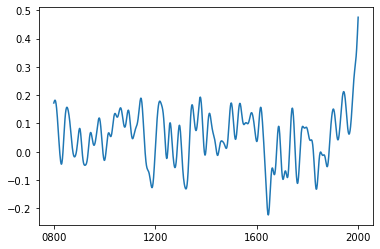

In [323]:
plt.plot(times_list[0],up_filt)

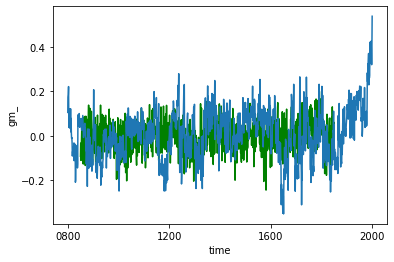

In [282]:
#mit allen zeitskalen, für d18O, db 1600 - 1900. no fractionation
utils.globalmean(prior['d18O']).plot.line('-',c='green')
plt.plot(times_list[0],np.concatenate(splitted_mean_none_1600[1]))


#no prior block anomaly correction

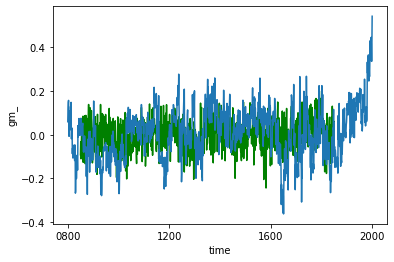

In [269]:
#mit allen zeitskalen, für d18O
utils.globalmean(prior['d18O']).plot.line('-',c='green')
plt.plot(times_list[0],np.concatenate(splitted_mean_none[1]))


#no prior block anomaly correction

In [ ]:
splitted_mean_none

In [130]:
splitted_mean_noanom=copy.deepcopy(splitted_mean)
splitted_std_noanom=copy.deepcopy(splitted_std)

In [138]:
utils.globalmean(prior['tsurf']).plot()

In [ ]:
prior_block.mean(axis=1)[:,100]-

In [241]:
plt.plot(times_list[0][:40],np.concatenate(splitted_mean_none[1])[:40])#.shape

In [153]:
#mit allen zeitskalen
plt.plot(times_list[0],np.concatenate(splitted_mean2[1]))#.shape

In [155]:
names_short_vector

array(['DB_0', 'gm_tsurf', 'gm_d18O', 'gm_prec', 'lm_tsurf'], dtype='<U32')

In [156]:
#mit allen zeitskalen, für d18O

utils.globalmean(prior['d18O']).plot.line('-',c='green')
#no prior block anomaly correction
plt.plot(times_list[0],np.concatenate(splitted_mean[2]))#.shape

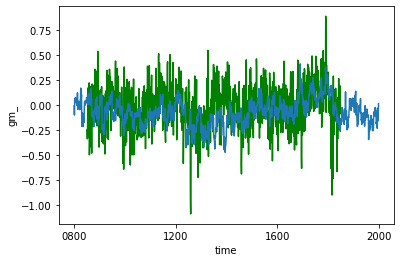

In [173]:
#mit allen zeitskalen. kleinerer fehler (0.01)

utils.globalmean(prior['tsurf']).plot.line('-',c='green')
#no prior block anomaly correction
plt.plot(times_list[0],np.concatenate(splitted_mean2[1]))#.shape

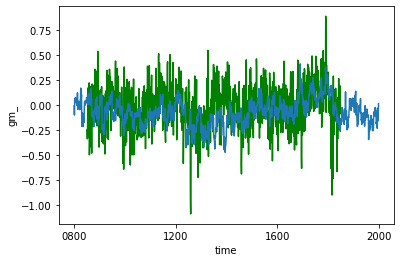

In [210]:
#mit allen zeitskalen. kleinerer fehler (0.01)

utils.globalmean(prior['tsurf']).plot.line('-',c='green')
#no prior block anomaly correction
plt.plot(times_list[0],np.concatenate(splitted_mean2[1]))#.shape

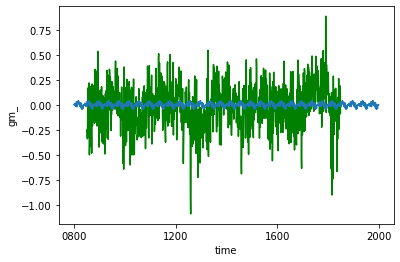

In [209]:
#mit allen zeitskalen. viel kleinerer fehler (0.001)

utils.globalmean(prior['tsurf']).plot.line('-',c='green')
#no prior block anomaly correction
plt.plot(times_list[0],np.concatenate(splitted_mean3[1]))#.shape

In [194]:
np.concatenate(splitted_mean3[1])

array([ 0.0006205 , -0.00045906,  0.00926632, ...,  0.01402492,
       -0.0017001 ,  0.00705768])

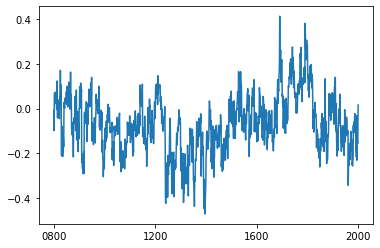

In [179]:
#mit allen zeitskalen. kleinerer fehler (0.01)
plt.plot(times_list[0],np.concatenate(splitted_mean2[1]))

In [154]:
#mit allen zeitskalen

utils.globalmean(prior['tsurf']).plot.line('-',c='green')
#no prior block anomaly correction
plt.plot(times_list[0],np.concatenate(splitted_mean[1]))#.shape

In [146]:
utils.globalmean(prior['tsurf']).plot.line('-',c='green')
#no prior block anomaly correction
plt.plot(times_list[0],np.concatenate(splitted_mean[1]))#.shape

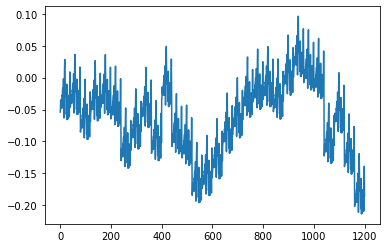

In [115]:
#no prior block anomaly correction
plt.plot(np.concatenate(splitted_mean[1]))#.shape

In [106]:
mean_array_final.shape

(1200, 151)

In [92]:
sites_avail[0]

array(['0.7', '0.21', '0.42', '0.52', '0.54', '0.60', '0.64', '0.94',
       '0.99', '0.104', '0.107', '0.130', '0.137', '0.154', '0.173',
       '0.181', '0.183', '0.186', '0.206', '0.207', '0.238', '0.250',
       '0.273'], dtype='<U5')

In [90]:
idx_list

[[3,
  8,
  18,
  20,
  21,
  24,
  26,
  33,
  34,
  37,
  38,
  46,
  48,
  54,
  62,
  65,
  66,
  68,
  73,
  74,
  84,
  89,
  96],
 [0,
  1,
  2,
  3,
  5,
  6,
  7,
  8,
  9,
  11,
  13,
  14,
  15,
  16,
  18,
  20,
  21,
  23,
  24,
  25,
  26,
  28,
  30,
  32,
  33,
  34,
  35,
  37,
  38,
  40,
  42,
  44,
  46,
  47,
  48,
  49,
  51,
  54,
  55,
  56,
  57,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  71,
  73,
  74,
  77,
  80,
  81,
  84,
  86,
  87,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  99],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  11,
  12,
  13,
  14,
  15,
  16,
  18,
  20,
  21,
  23,
  24,
  25,
  26,
  28,
  29,
  30,
  32,
  33,
  34,
  35,
  37,
  38,
  40,
  42,
  43,
  44,
  46,
  47,
  48,
  49,
  50,
  51,
  54,
  55,
  56,
  57,
  59,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  71,
  72,
  73,
  74,
  75,
  77,
  80,
  81,
  82,
  84,
  86,
  87,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  99],
 [0,
  1,
  2,
 

In [88]:
lisst[0]

<xarray.DataArray (time: 1200, site: 23)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,  0.3758697 , ...,         nan,
                nan,         nan],
       ...,
       [ 1.43499405, -0.68329564,         nan, ...,         nan,
         0.87769231,  0.15687251],
       [ 1.39452957, -0.72329564,         nan, ...,         nan,
         1.42769231,  0.28187251],
       [        nan, -0.67329564,         nan, ...,         nan,
         1.33769231,  0.38187251]])
Coordinates:
  * site     (site) <U5 '0.7' '0.21' '0.42' '0.52' ... '0.238' '0.250' '0.273'
  * time     (time) object 0800-01-01 00:00:00 ... 1999-01-01 00:00:00
Attributes:
    DB_members:  [23]

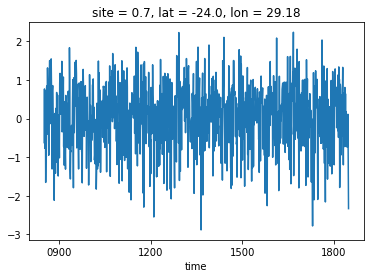

In [73]:
HXfull_all_fin.sel(site='0.7').plot()

In [82]:
rand=np.random.randint(1000,size=100)

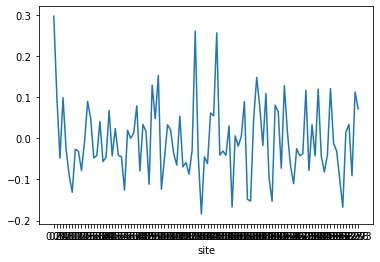

In [83]:
HXfull_all_fin[rand].mean(axis=0).plot()

In [ ]:
lisst

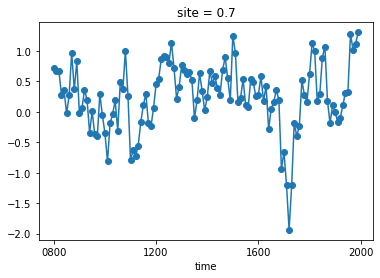

In [84]:
#pp_y_all_c[0].sel(site='0.7').plot.line('o-',color='green',markersize=1)
lisst[2].sel(site='0.7').plot.line('o-')

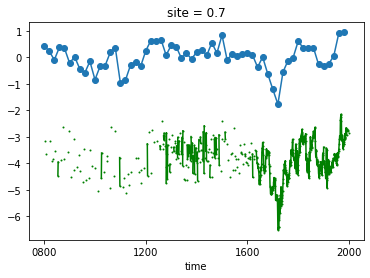

In [46]:
pp_y_all_c[0].sel(site='0.7').plot.line('o-',color='green',markersize=1)
lisst[2].sel(site='0.7').plot.line('o-')

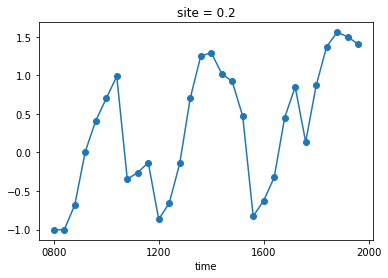

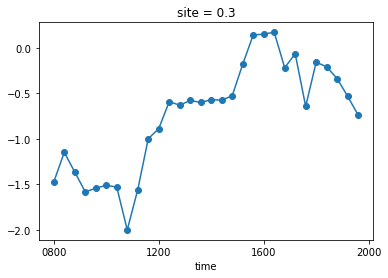

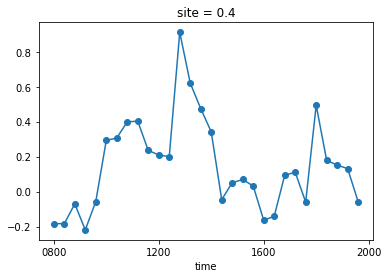

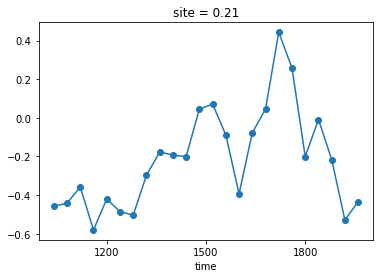

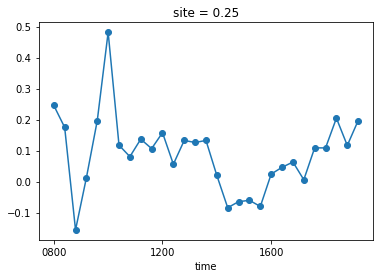

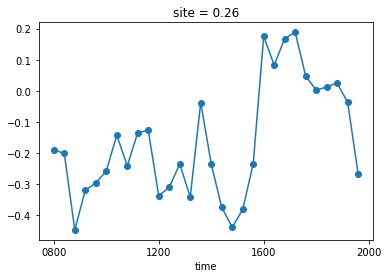

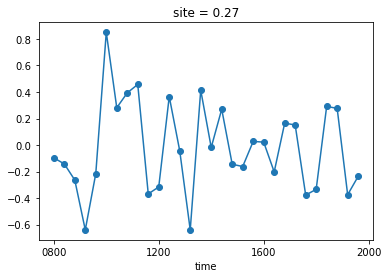

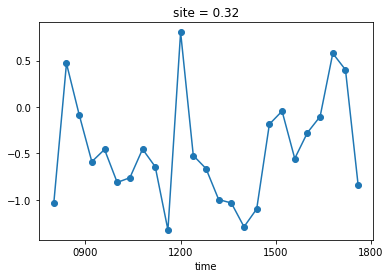

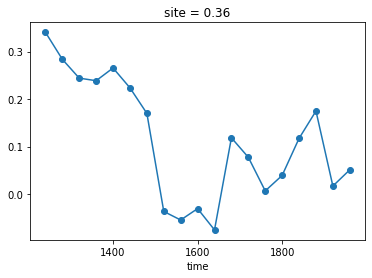

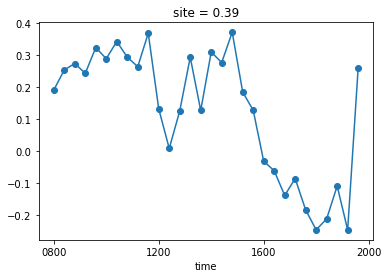

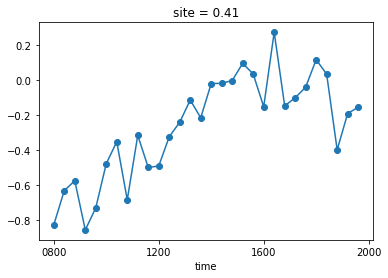

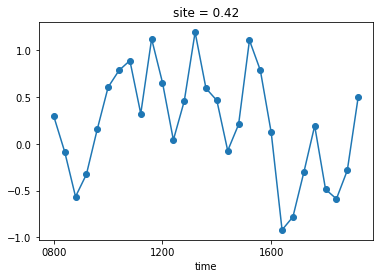

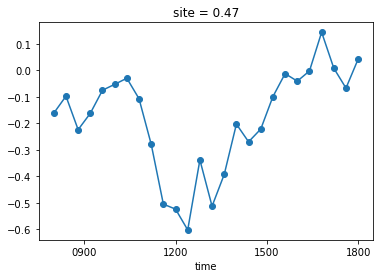

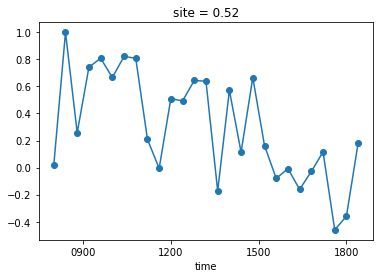

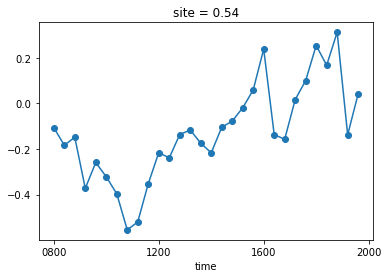

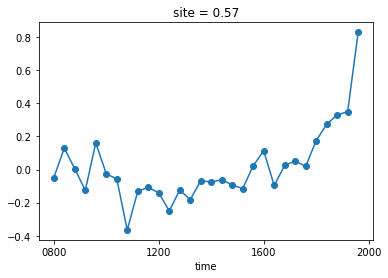

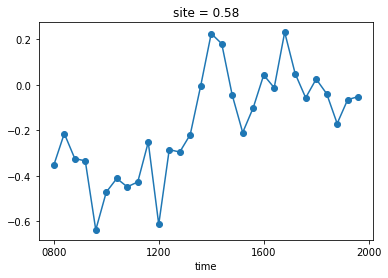

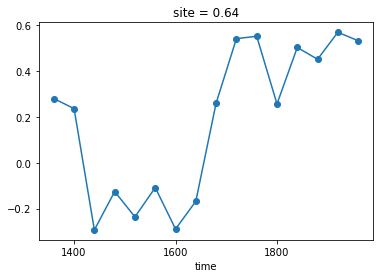

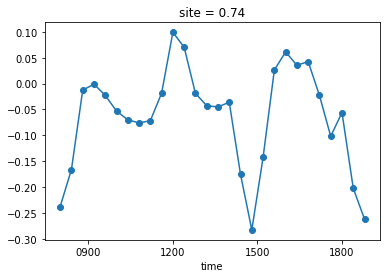

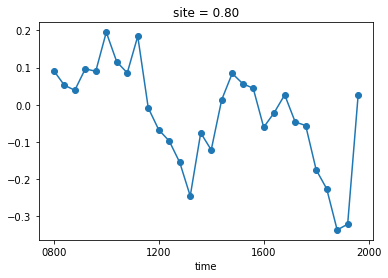

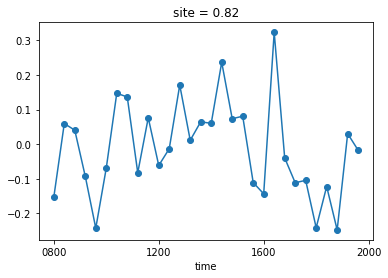

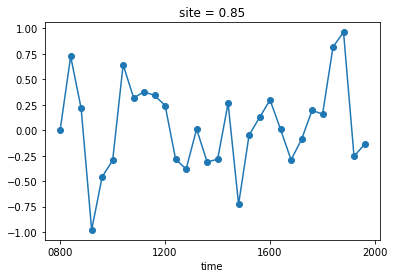

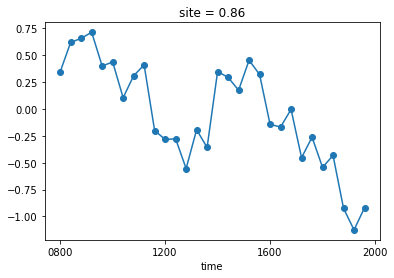

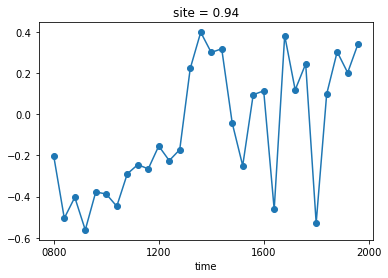

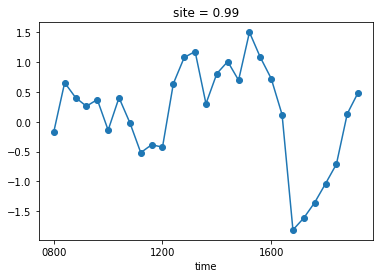

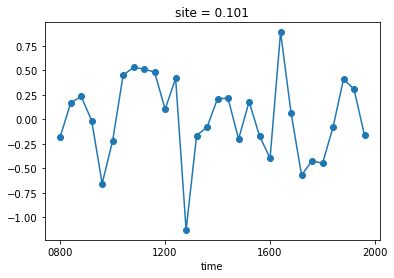

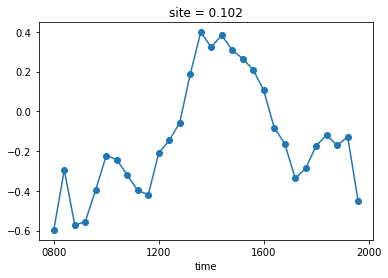

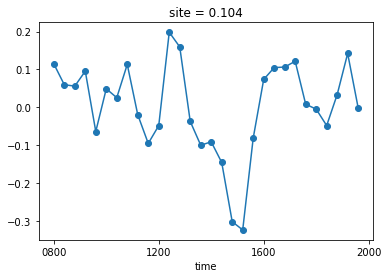

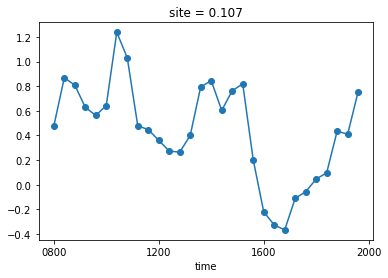

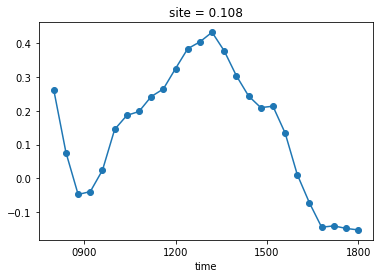

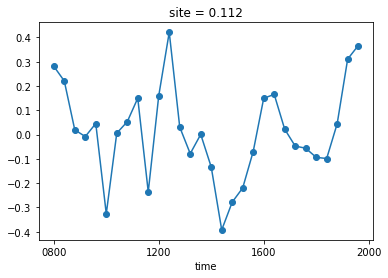

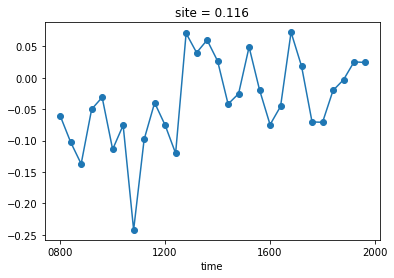

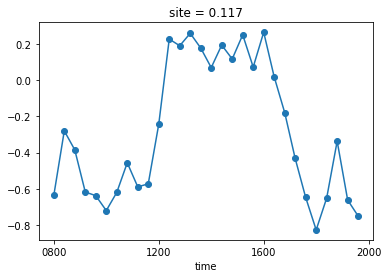

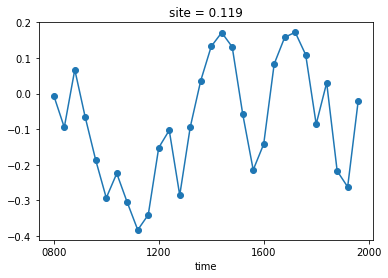

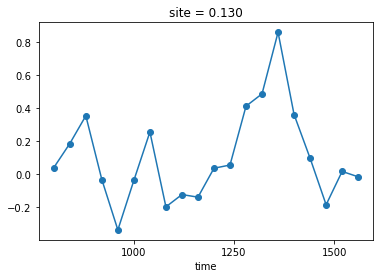

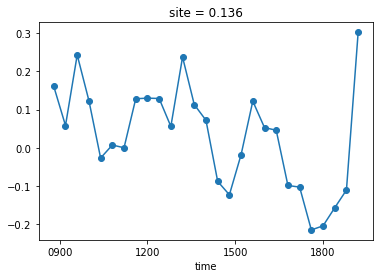

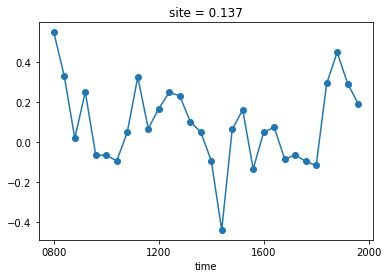

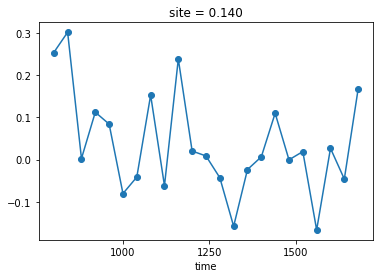

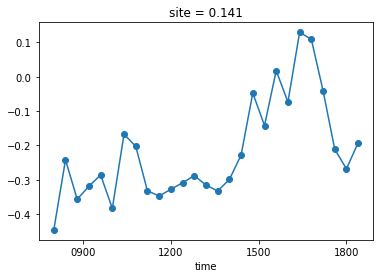

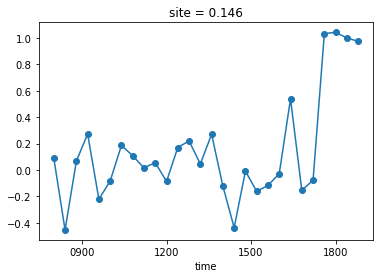

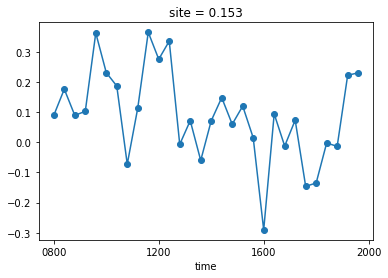

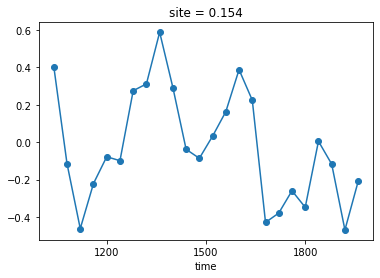

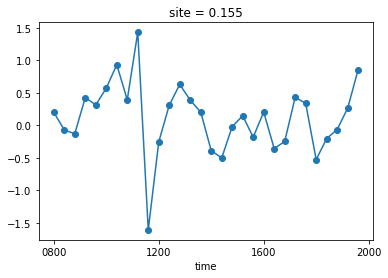

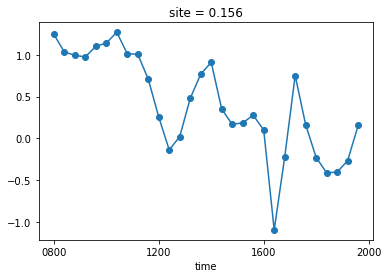

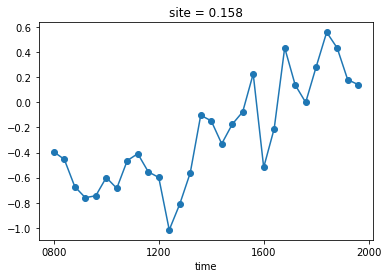

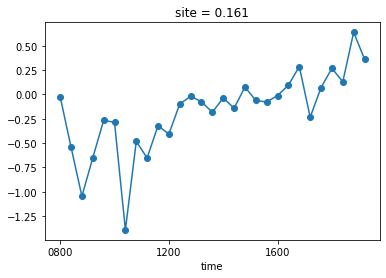

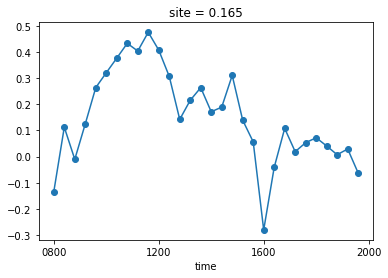

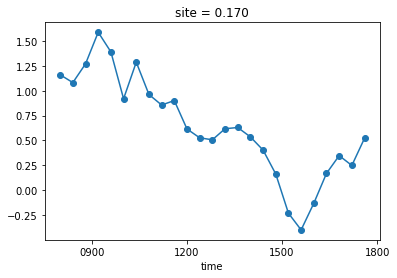

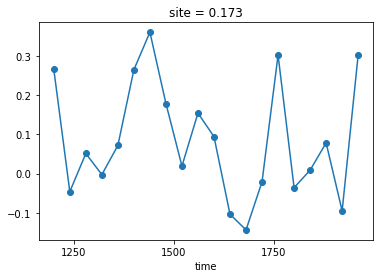

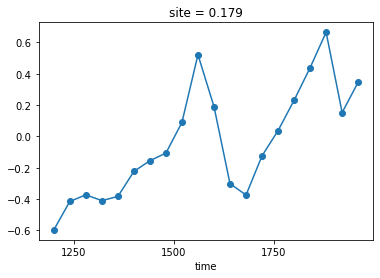

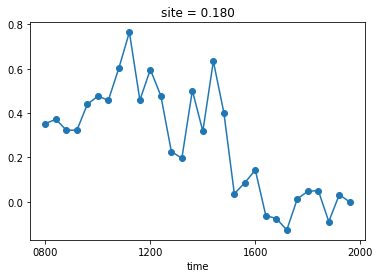

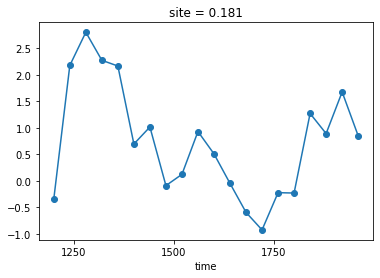

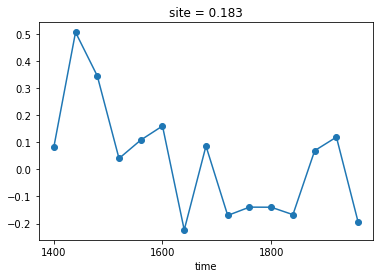

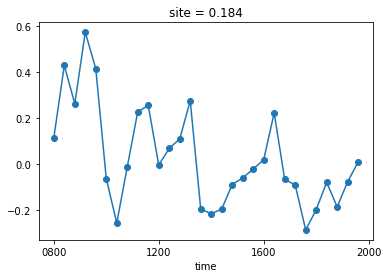

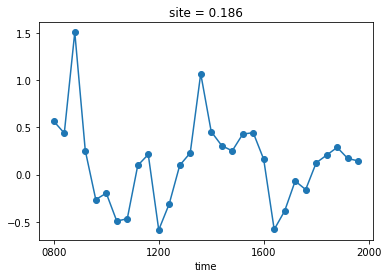

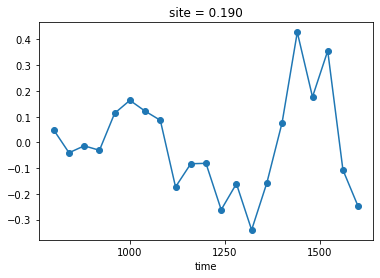

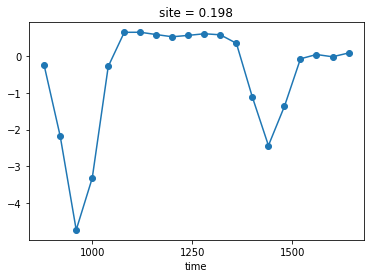

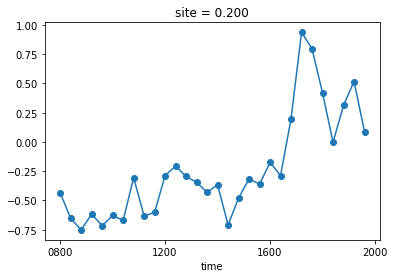

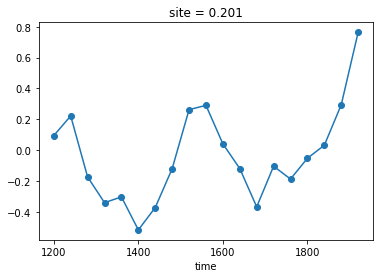

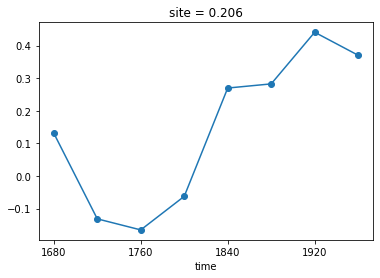

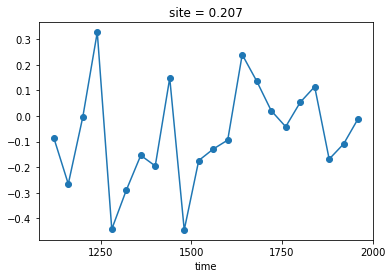

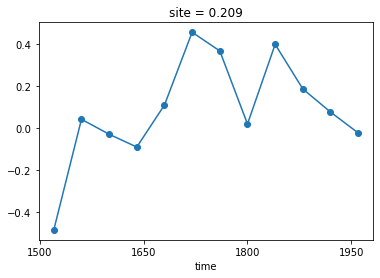

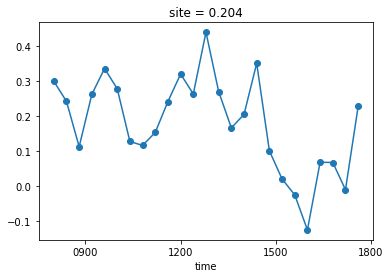

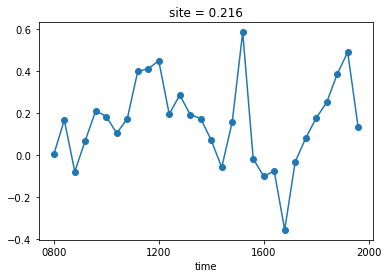

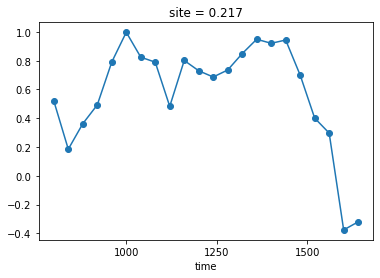

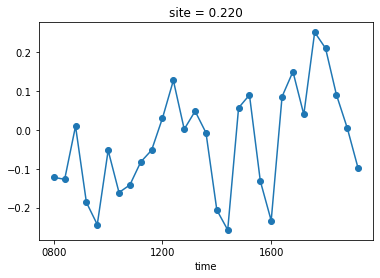

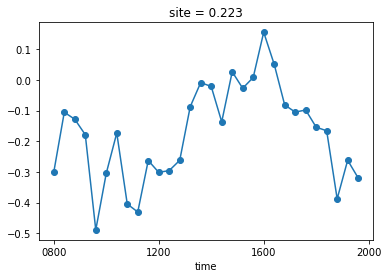

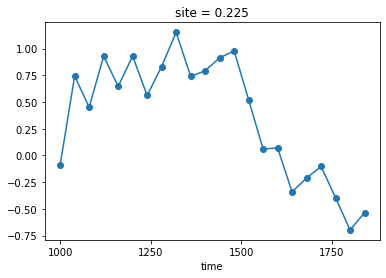

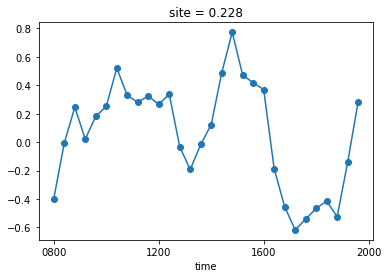

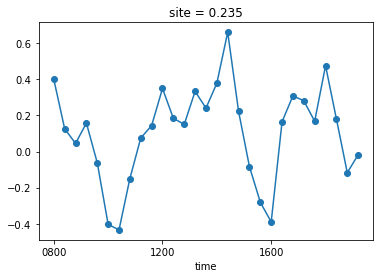

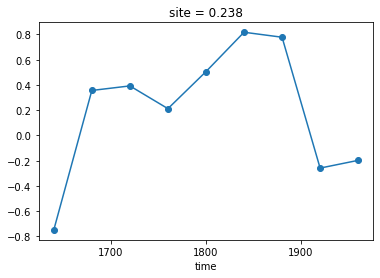

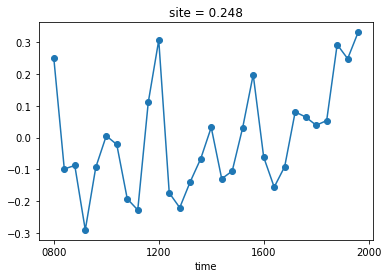

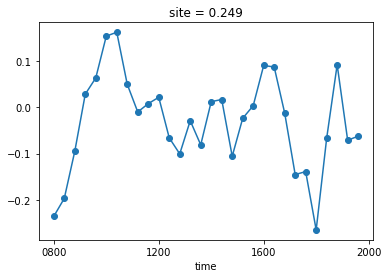

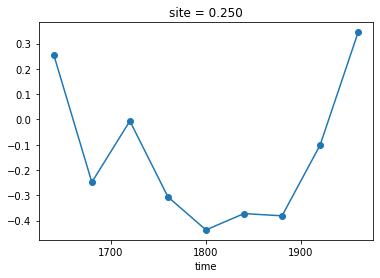

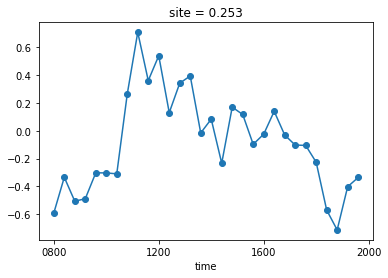

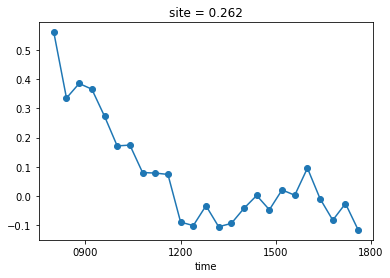

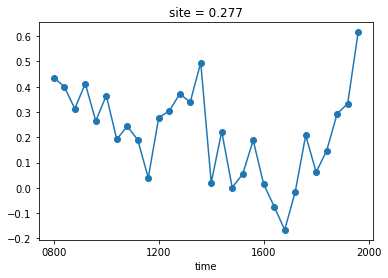

In [68]:
for site in lisst[4].site:
    lisst[4].sel(site=site).plot.line('o-')
    plt.show()

In [ ]:
lisst[2].sel(site='0.7').plot.line('o-')

In [26]:
pp_y_all

[<xarray.DataArray 'd18O' (time: 1200, site: 110)>
 [132000 values with dtype=float64]
 Coordinates:
   * site        (site) <U5 '0.2' '0.3' '0.4' '0.7' ... '0.277' '0.278' '0.293'
   * time        (time) object 0800-01-01 00:00:00 ... 1999-01-01 00:00:00
     lat         (site) float64 ...
     lon         (site) float64 ...
     elev        (site) float64 ...
     mineralogy  (site) object ...
     sitename    (site) object ...]